In [1]:
from qiskit import *
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.special import erf
# Other imports
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

import mitiq

# Qiskit for pulse 
from qiskit import pulse

from qiskit import *
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, ShiftPhase
from qiskit.pulse.library import drag, GaussianSquare, Drag
from qiskit.visualization import SchedStyle
from qiskit.providers.aer import AerSimulator

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

from qiskit.circuit.gate import Gate

# Fake backend
#from qiskit.test.mock import FakeAthens

from scipy import integrate

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='iowa-state-uni-1', project='main')
backend = provider.get_backend('ibmq_bogota')
#backend = FakeAthens()
properties = backend.properties()

In [4]:
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [5]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

In [6]:
def flip(n,i,L):  # flip the spin on i site for state n like flip the 0 site of '10001'->'00001'
    ii=2**(L-i-1)
    nn=2**L
    if int(bin(n+nn)[3:][i])==1:
        return binaryToDecimal(int(bin(n-ii)[2:]))
    if int(bin(n+nn)[3:][i])==0:
        return binaryToDecimal(int(bin(n+ii)[2:]))

#The function to covert the binary number to the decimal number.
#@jit
def binaryToDecimal(binary): 
      
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal  

#@jit 
def spin_x(i,L):
    n=2**L
    X=np.zeros((n,n))
    for j in range(n):
        X[j,flip(j,i,L)]=1
    return X

#Pauli matrix y
#@jit
def spin_y(i,L):
    n=2**L
    Y=np.zeros((n,n),dtype=complex)
    for j in range(n):
        Y[j,flip(j,i,L)]=1j*(-1)**(int(bin(j+n)[3:][i]))
    return Y

#Pauli matrix z
#@jit
def spin_z(i,L):
    n=2**L
    Z=np.zeros((n,n))
    #a=2**L-1
    for j in range(n):
        Z[j,j]=2*int(bin(j+n)[3:][i])-1
    return Z

In [7]:
def Rzx(theta):
    rzx=np.zeros((4,4),dtype=complex)
    for i in range(4):
        rzx[i,i]=np.cos(theta/2)
    rzx[1,0]=-1j*np.sin(theta/2)
    rzx[0,1]=-1j*np.sin(theta/2)
    rzx[3,2]=1j*np.sin(theta/2)
    rzx[2,3]=1j*np.sin(theta/2)
    return rzx

def Rz(theta,q): #q for which qubit you apply on #theta how many angle you want to rotate along with z axis
    rz=np.cos(theta/2)*np.eye(4)+1j*np.sin(theta/2)*spin_z(q,2)
    return rz

def Ry(theta,q): #q for which qubit you apply on #theta how many angle you want to rotate along with y axis
    ry=np.cos(theta/2)*np.eye(4)+1j*np.sin(theta/2)*spin_y(q,2)
    return ry

def Rx(theta,q): #q for which qubit you apply on #theta how many angle you want to rotate along with x axis
    rx=np.cos(theta/2)*np.eye(4)+1j*np.sin(theta/2)*spin_x(q,2)
    return rx

In [8]:
# Rzz(-np.pi/2) pulse

C=np.dot(Rzx(np.pi/4),Ry(-np.pi/2,1)) #spin_x(0,2) 0 for first qubit. 2 means total # of qubits
C1=np.dot(Rx(np.pi,0),C)
C2=np.dot(Rzx(-np.pi/4),C1)
C3=np.dot(Rx(np.pi,0),C2)
C4=np.dot(Ry(np.pi/2,1),C3)
C4

array([[-7.07106781e-01-7.07106781e-01j,  1.62588398e-17+0.00000000e+00j,
         4.32978028e-17+1.04530143e-16j, -1.25603029e-33+9.28285703e-34j],
       [ 1.62588398e-17+0.00000000e+00j, -7.07106781e-01+7.07106781e-01j,
         1.25603029e-33+9.28285703e-34j, -4.32978028e-17+1.04530143e-16j],
       [-4.32978028e-17+1.04530143e-16j,  1.25603029e-33+9.28285703e-34j,
        -7.07106781e-01+7.07106781e-01j,  1.62588398e-17+0.00000000e+00j],
       [-1.25603029e-33+9.28285703e-34j,  4.32978028e-17+1.04530143e-16j,
         1.62588398e-17+0.00000000e+00j, -7.07106781e-01-7.07106781e-01j]])

In [9]:
c=np.dot(spin_x(0,2),Ry(np.pi/2,0))
np.dot(Ry(-np.pi/2,0),c)

array([[ 1.00000000e+00+0.j,  0.00000000e+00+0.j,  4.26642159e-17+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  1.00000000e+00+0.j,  0.00000000e+00+0.j,
         4.26642159e-17+0.j],
       [-4.26642159e-17+0.j,  0.00000000e+00+0.j, -1.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j, -4.26642159e-17+0.j,  0.00000000e+00+0.j,
        -1.00000000e+00+0.j]])

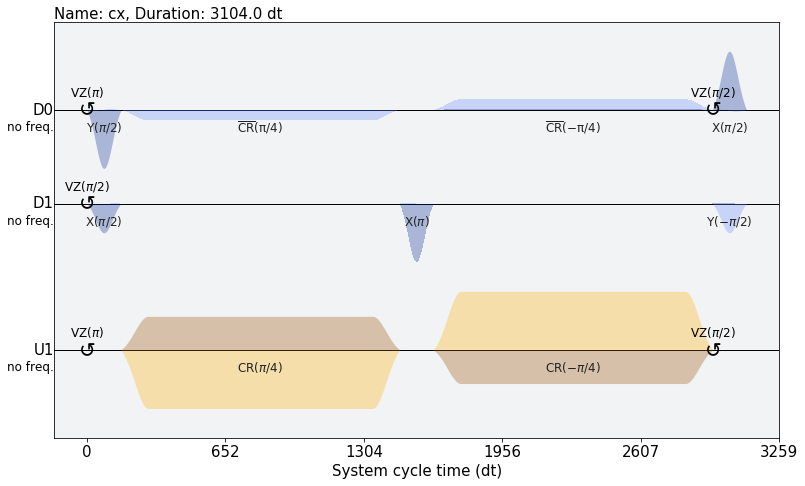

In [10]:
inst_sched_map.get('cx', qubits=[0, 1]).draw('mpl')

In [11]:
inst_sched_map.get('cx', qubits=[0, 1]).instructions

((0, ShiftPhase(-3.141592653589793, DriveChannel(0))),
 (0, ShiftPhase(-1.5707963267948966, DriveChannel(1))),
 (0, ShiftPhase(-1.5707963267948966, ControlChannel(0))),
 (0, ShiftPhase(-3.141592653589793, ControlChannel(1))),
 (0, ShiftPhase(-1.5707963267948966, ControlChannel(3))),
 (0,
  Play(Drag(duration=160, amp=(-0.0011205562163554461+0.09551277981060023j), sigma=40, beta=-1.1574521876381278, name='Y90p_d0'), DriveChannel(0), name='Y90p_d0')),
 (0,
  Play(Drag(duration=160, amp=(0.08692075412718299-0.0012938140454329997j), sigma=40, beta=-0.827531039829235, name='X90p_d1'), DriveChannel(1), name='X90p_d1')),
 (160,
  Play(GaussianSquare(duration=1312, amp=(0.017272862125938825+0.0012131203257682327j), sigma=64, width=1056, name='CR90p_d0_u1'), DriveChannel(0), name='CR90p_d0_u1')),
 (160,
  Play(GaussianSquare(duration=1312, amp=(0.30156033012158323-0.1729956115665404j), sigma=64, width=1056, name='CR90p_u1'), ControlChannel(1), name='CR90p_u1')),
 (1472,
  Play(Drag(duration=160

In [12]:
c=np.dot(spin_x(0,2),Ry(np.pi/2,0))
np.dot(Ry(-np.pi/2,0),c)

array([[ 1.00000000e+00+0.j,  0.00000000e+00+0.j,  4.26642159e-17+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  1.00000000e+00+0.j,  0.00000000e+00+0.j,
         4.26642159e-17+0.j],
       [-4.26642159e-17+0.j,  0.00000000e+00+0.j, -1.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j, -4.26642159e-17+0.j,  0.00000000e+00+0.j,
        -1.00000000e+00+0.j]])

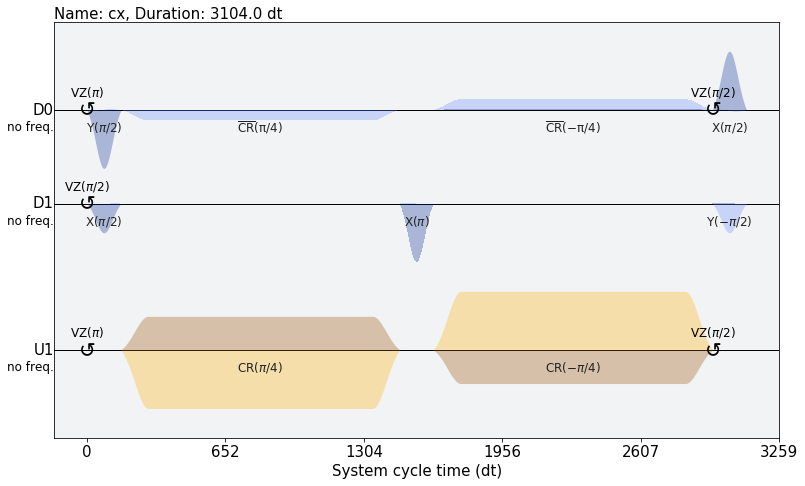

In [13]:
inst_sched_map.get('cx', qubits=[0, 1]).draw('mpl')

In [14]:
inst_sched_map.get('cx', qubits=[0, 1]).instructions

((0, ShiftPhase(-3.141592653589793, DriveChannel(0))),
 (0, ShiftPhase(-1.5707963267948966, DriveChannel(1))),
 (0, ShiftPhase(-1.5707963267948966, ControlChannel(0))),
 (0, ShiftPhase(-3.141592653589793, ControlChannel(1))),
 (0, ShiftPhase(-1.5707963267948966, ControlChannel(3))),
 (0,
  Play(Drag(duration=160, amp=(-0.0011205562163554461+0.09551277981060023j), sigma=40, beta=-1.1574521876381278, name='Y90p_d0'), DriveChannel(0), name='Y90p_d0')),
 (0,
  Play(Drag(duration=160, amp=(0.08692075412718299-0.0012938140454329997j), sigma=40, beta=-0.827531039829235, name='X90p_d1'), DriveChannel(1), name='X90p_d1')),
 (160,
  Play(GaussianSquare(duration=1312, amp=(0.017272862125938825+0.0012131203257682327j), sigma=64, width=1056, name='CR90p_d0_u1'), DriveChannel(0), name='CR90p_d0_u1')),
 (160,
  Play(GaussianSquare(duration=1312, amp=(0.30156033012158323-0.1729956115665404j), sigma=64, width=1056, name='CR90p_u1'), ControlChannel(1), name='CR90p_u1')),
 (1472,
  Play(Drag(duration=160

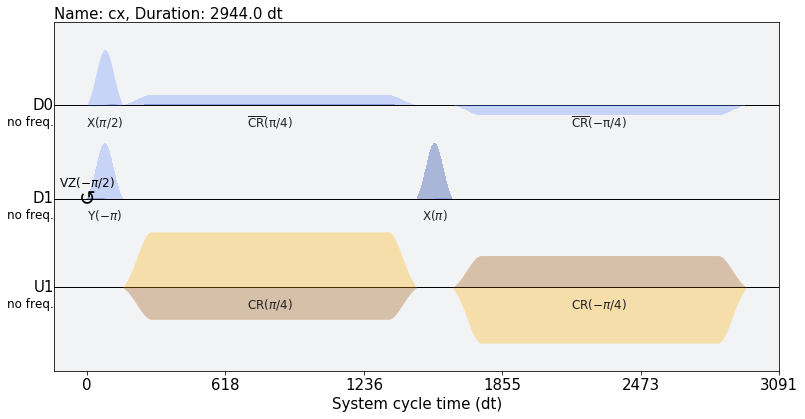

In [15]:
inst_sched_map.get('cx', qubits=[1, 0]).draw('mpl')

In [16]:
inst_sched_map.get('cx', qubits=[1, 0]).instructions

((0, ShiftPhase(1.5707963267948966, DriveChannel(1))),
 (0, ShiftPhase(1.5707963267948966, ControlChannel(0))),
 (0, ShiftPhase(1.5707963267948966, ControlChannel(3))),
 (0,
  Play(Drag(duration=160, amp=(0.09551277981060023+0.0011205562163554442j), sigma=40, beta=-1.1574521876381278, name='X90p_d0'), DriveChannel(0), name='X90p_d0')),
 (0,
  Play(Drag(duration=160, amp=(-3.195518633588107e-17-0.17395593220907732j), sigma=40, beta=0.7015278131213479, name='Ym_d1'), DriveChannel(1), name='Ym_d1')),
 (160,
  Play(GaussianSquare(duration=1312, amp=(0.017272862125938825+0.0012131203257682327j), sigma=64, width=1056, name='CR90p_d0_u1'), DriveChannel(0), name='CR90p_d0_u1')),
 (160,
  Play(GaussianSquare(duration=1312, amp=(0.30156033012158323-0.1729956115665404j), sigma=64, width=1056, name='CR90p_u1'), ControlChannel(1), name='CR90p_u1')),
 (1472,
  Play(Drag(duration=160, amp=(0.17395593220907732+0j), sigma=40, beta=0.7015278131213479, name='Xp_d1'), DriveChannel(1), name='Xp_d1')),
 (16

In [17]:
def cx_pulse_instructions(qc: int, qt: int):
    """Retrieve the CNOT pulse schedule for the given
    qubit pair from the backend defaults.
    
    Args:
      qc: control qubit index
      qt: target qubit index
    """
    if [qc, qt] not in backend_config.coupling_map:
        print('Qubit pair has no direct cross resonance!')
    else:
        cx = inst_sched_map.get('cx', qubits=[qc, qt])
        return cx

def Exract_GaussianSquare(q1, q2):
    """Retrieve the Gaussiacross resonance pulse waveform
    for the qubit pair from the cx (CNOT) schedule.
    
    Args:
      q1: control qubit index
      q2: target qubit index
    """
    cx = cx_pulse_instructions(q1, q2)
    cx1 = cx_pulse_instructions(q2, q1)
       
    if cx.instructions[-1][0] < cx1.instructions[-1][0]: # get longer cnot gate pulse schedule 
        cx=cx1
    idx = 0
    Dr_gs = [] # get the gaussiansquare pulse of drive channel
    cr_gs = [] # get the gaussiansquare pulse of control channel
    control_channel='' # get the corresponding control channel for q1 and q2
    Drive_Channel=''    # get the corresponding drive channel with gaussiansquare pulse
    another_Drive_Channel='' # get another drive channel
    
    #look for them
    
    N = 1
    for i in range(len(cx.instructions)):
        if type(cx.instructions[i][1]) is ShiftPhase and type(cx.instructions[i][1].channel) is DriveChannel\
        and cx.instructions[i][1].phase == -math.pi/2 and N == 1 :
            
            another_Drive_Channel=cx.instructions[i][1].channels[0]
            
        if type(cx.instructions[i][1].channels[0]) is ControlChannel and type(cx.instructions[i][1]) is Play\
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            cr_gs.append(cx.instructions[i][1].pulse)

            control_channel=cx.instructions[i][1].channels[0]

        if type(cx.instructions[i][1].channels[0]) is DriveChannel and type(cx.instructions[i][1]) is Play \
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            Dr_gs.append(cx.instructions[i][1].pulse)

            Drive_Channel=cx.instructions[i][1].channels[0]
        if type(cx.instructions[i][1]) is Play:
            N=0

    return control_channel, cr_gs, Drive_Channel, Dr_gs, another_Drive_Channel


def Get_Shift_phase_CRTL_Chan(q1, q2): # When driving channel is phase shifted, the corresponding control channel need to be phase shifted. 
    """Get the driving channels' corresponding control channels
    
    Args:
      q1: qubit
      q2: qubit
    out_put: 
      control_chan1: the corresponding control channel of driving channel with 
    """
    cx1 = cx_pulse_instructions(q1, q2)
    cx2 = cx_pulse_instructions(q2, q1)
    if cx1.instructions[-1][0] > cx2.instructions[-1][0]:
        cx1, cx2 = cx2, cx1
    control_chan0 = []
    control_chan1 = []
    for i in range(len(cx2.instructions)):
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi/2 :
            control_chan0.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi :
            control_chan1.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is Play:
            break

    return control_chan0, control_chan1 


def Rzz_90_gate_schedule (q0,q1):
    uchan, cr_pulse, Dchan, dr_pulse, another_Dchan = Exract_GaussianSquare(q0, q1)
    #Y_chan, X_chan = Get_XY_chan(q0,q1)
    control_chan0, control_chan1 = Get_Shift_phase_CRTL_Chan(q0, q1)
    
    
    Y_q = Dchan.index # corresponding 
    
    X_q = another_Dchan.index
    
    Y90p = inst_sched_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions
    
    X_180 = inst_sched_map.get('x', qubits=[X_q]).instructions[0][1].pulse
    
    for Y in Y90p:
        if type(Y[1]) is Play:
            Y_pulse = Y[1].pulse
            
    drive_samples = Y_pulse.duration
    
    cr_samples = cr_pulse[0].duration
  
    Rzz_90_schedule = pulse.Schedule(name="RZZ gate m90 pulse") 
    
    Rzz_90_schedule |= ShiftPhase(-math.pi, Dchan) #<< int(2*cr_samples+2*drive_samples)
    
    for chan in control_chan1:
        Rzz_90_schedule |= ShiftPhase(-math.pi, chan) #<< int(2*cr_samples+2*drive_samples)
    
    Rzz_90_schedule |= Play(Y_pulse, Dchan)
    
    Rzz_90_schedule |= ShiftPhase(-math.pi, Dchan) << int(drive_samples)
    
    for chan in control_chan1: 
        Rzz_90_schedule |= ShiftPhase(-math.pi, chan) << int(drive_samples)

    
    Rzz_90_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
    Rzz_90_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
    Rzz_90_schedule |= Play(X_180, another_Dchan) << int(cr_samples+drive_samples)

    Rzz_90_schedule |= Play(dr_pulse[1], Dchan) << int(cr_samples+2*drive_samples)
    Rzz_90_schedule |= Play(cr_pulse[1], uchan) << int(cr_samples+2*drive_samples)
    
    Rzz_90_schedule |= Play(X_180, another_Dchan) << int(2*cr_samples+2*drive_samples)

    Rzz_90_schedule |= Play(Y_pulse, Dchan) << int(2*cr_samples+2*drive_samples)
    
    return Rzz_90_schedule

def Rzz_gate_schedule (q0,q1,theta):
    
    uchan, cr_pulse, Dchan, dr_pulse, another_Dchan = Exract_GaussianSquare(q0, q1)
    #Y_chan, X_chan = Get_XY_chan(q0,q1)
    control_chan0, control_chan1 = Get_Shift_phase_CRTL_Chan(q0, q1)
    
    Frac = 2*np.abs(theta)/math.pi
    
    Y_q = Dchan.index
    
    X_q = another_Dchan.index
    
    Y90p = inst_sched_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions
    
    X_180 = inst_sched_map.get('x', qubits=[X_q]).instructions[0][1].pulse
    
    ### find out Y_90 pulse 
    
    for Y in Y90p:
        
        if type(Y[1]) is Play:
            
            Y_pulse = Y[1].pulse
            
    ###
            
    drive_samples = Y_pulse.duration # The duration of Y pulse
    
    cr_samples = cr_pulse[0].duration # The duration gaussiansquare pulse
    
    cr_width= cr_pulse[0].width # gaussiansquare pulse's width
    
    cr_sigma = cr_pulse[0].sigma # gaussiansquare pulse's standard error
    
    cr_amp = np.abs(cr_pulse[0].amp)
    
    number_std = (cr_samples-cr_width)/cr_sigma
    
    #Area_g = cr_amp*cr_sigma*np.sqrt(2*np.pi)*erf(number_std) # paper
    
    Area_g = cr_amp*cr_sigma*np.sqrt(2*np.pi)*erf(number_std/2/np.sqrt(2)) #modified
    
    Area_pi_2 = cr_width*cr_amp+Area_g 
    
    dr_sigma = dr_pulse[0].sigma
    
    dr_amp = np.abs(dr_pulse[0].amp)
    
    Area_theta = Frac * Area_pi_2
    
    if Area_theta > Area_g:
        
        New_width = (Area_theta-Area_g)/cr_amp
        
        new_duration = math.ceil((New_width+number_std*cr_sigma)/16)*16
        
        New_width = new_duration-number_std*cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        
    else:
        
        New_amp_cr =  cr_pulse[0].amp*Area_theta/Area_g
        
        New_amp_dr= dr_pulse[0].amp*Area_theta/Area_g
        
        new_duration = number_std * cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_amp, sigma=cr_sigma, width=0)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_amp, sigma=cr_sigma, width=0)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_amp, sigma=dr_sigma, width=0)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_amp, sigma=dr_sigma, width=0)
        
    # Set up the Rzz schedule
    if theta < 0 :
  
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_-90 pulse
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) 
    
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) 
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(drive_samples)
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_90 pulse

        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
    
        return RZZ_schedule
    
    else:
        
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_90 pulse
    
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_-90 pulse
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+2*drive_samples)
        
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+3*drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+3*drive_samples)
    
        return RZZ_schedule


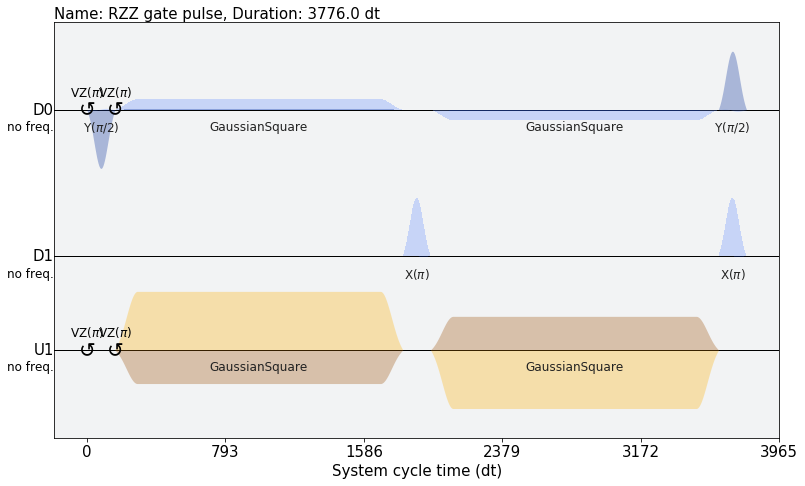

In [18]:
Rzz_gate_schedule (0,1,-2).draw()

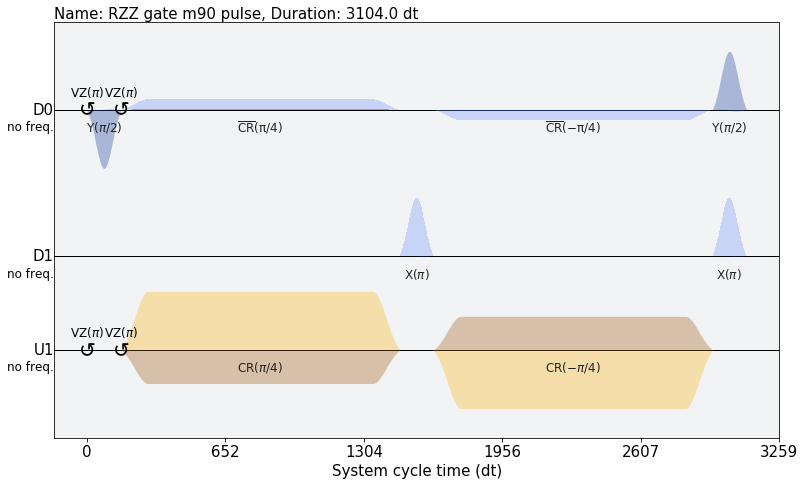

In [19]:
Rzz_90_gate_schedule(0,1).draw()

In [20]:
def h_Z(qc,h,dt):
    
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    #qc.cx(0,1)
    
    qc.rzz(-2*V*dt,0,1)
    
    #qc.cx(0,1)
    
    #qc.cx(2,3)
    
    qc.rzz(-2*V*dt,2,3)
    
    #qc.cx(2,3)
    
    #qc.cx(1,2)
    
    qc.rzz(-2*V*dt,1,2)
    
    #qc.cx(1,2)
    
    #qc.cx(3,4)
    
    qc.rzz(-2*V*dt,3,4)
    
    #qc.cx(3,4)
    

In [21]:
def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        # add the custom pulse gate into circuit
            
        Trotter_circuit.add_calibration('rzz', [0,1], Rzz_gate_schedule (0,1,-2*V*dt), [-2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [2,3], Rzz_gate_schedule (2,3,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [1,2], Rzz_gate_schedule (1,2,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [3,4], Rzz_gate_schedule (3,4,-2*V*dt), [-2*V*dt])
            
        Trotter_circuit.measure_all()
        
        Trotter_circuit = transpile(Trotter_circuit, backend) # compile into specific backend
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [22]:
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

n = 20

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

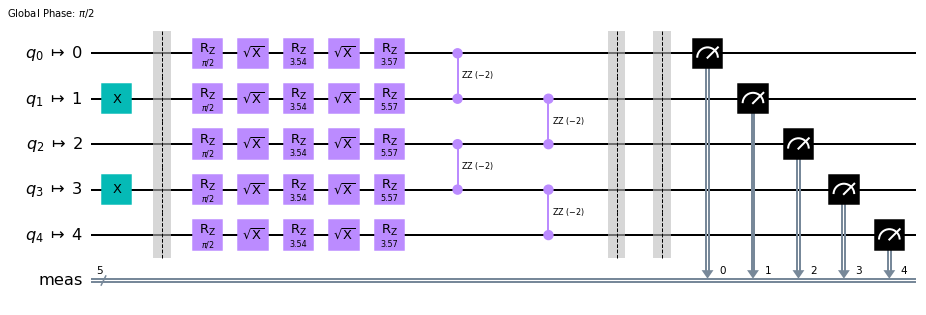

In [23]:
Trotter_circuit[1].draw('mpl')

In [24]:
def post_selection(bit_str):
    """This function takes in a bitstring, and will return False iff 
    there is a 1 next to another 1 in the given bitstring.
    This does NOT consider a bitstring with 1s on either end as next to one another,
    i.e. given a string of the form '10...01', this function should return False"""
    new_str = '0' + bit_str[0:len(bit_str)]
    for i in range(0,len(bit_str)+1):
        if (new_str[i] == '1') & (new_str[i] == new_str[i-1]):
            return False
    return True

def post_selected_expval(counts, qubit):
    """This function takes in the counts from a circuit execution, as well as a qubit index, 
    and outputs <Z> for that qubit after post-selection"""
    copy_counts = counts.copy()
    
    total = []

    for x in counts.keys():
        if not post_selection(x):
            copy_counts.pop(x)

    for x in copy_counts:
        total.append(copy_counts[x])

    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]

    prob = one_counts / total

    expval = 2*prob - 1
    
    return expval

In [25]:
#This needs to be 5, since we have 5 qubits in our circuit.
qr = QuantumRegister(5)

# noise_model = NoiseModel.from_backend(backend)

qubit_list = [0,1,2,3,4]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

qasm_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(meas_calibs, backend) #Aer.get_backend('qasm_simulator'))
qobj = assemble(t_qc, shots=10000)

#note that the noise model isn't used until here. All the code in this cell above this comment is
# simply doing calibration of the circuit.
cal_results = qasm_sim.run(qobj, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

meas_filter = meas_fitter.filter

In [26]:
def SwapTestExecutor(circuits, backend, shots, post_sel_func, qubit):
    scale_factors = [1.0, 2.0, 3.0]
    folded_circuits = []
    for circuit in circuits:
        folded_circuits.append([mitiq.zne.scaling.fold_gates_at_random(circuit, scale) for scale in scale_factors])
    folded_circuits = list(itertools.chain(*folded_circuits))

    job = qiskit.execute(
        experiments=folded_circuits,
        backend=backend,
        optimization_level=0,
        shots=shots
    )

    results = job.result()
    mit_results = meas_filter.apply(results)

    expectation_values = []

    for t in range(len(folded_circuits)):
        expectation_values.append(post_selected_expval(mit_results.get_counts(t),qubit))

    zero_noise_values = []
    if isinstance(backend, qiskit.providers.aer.backends.qasm_simulator.QasmSimulator): # exact_sim
        for i in range(len(circuits)):
            zero_noise_values.append(np.mean(expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
    else: #device_sim
        fac = mitiq.zne.inference.LinearFactory(scale_factors)
        for i in range(len(circuits)):
            zero_noise_values.append(fac.extrapolate(scale_factors, 
            expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))

    return zero_noise_values

In [27]:
job = qiskit.execute(
        experiments=Trotter_circuit,
        backend=backend,
        optimization_level=0,
        shots=8192
    )
results = job.result()
counts = results.get_counts()

In [28]:
print(counts)

[{'00000': 35, '10000': 3, '10010': 15, '10110': 1, '11000': 4, '11010': 127, '11011': 1, '11110': 5, '00010': 773, '00011': 3, '00110': 16, '01000': 263, '01001': 2, '01010': 6743, '01011': 35, '01100': 11, '01110': 155}, {'00000': 338, '00001': 29, '10000': 19, '10001': 5, '10010': 208, '10011': 12, '10100': 1, '10101': 1, '10110': 13, '11000': 26, '11001': 3, '11010': 218, '11011': 15, '11100': 4, '11110': 18, '11111': 1, '00010': 3516, '00011': 210, '00100': 23, '00101': 1, '00110': 240, '00111': 18, '01000': 244, '01001': 22, '01010': 2621, '01011': 170, '01100': 16, '01101': 1, '01110': 187, '01111': 12}, {'00000': 494, '00001': 46, '10000': 72, '10001': 6, '10010': 275, '10011': 18, '10100': 2, '10110': 46, '10111': 8, '11000': 81, '11001': 10, '11010': 292, '11011': 16, '11100': 8, '11110': 52, '11111': 4, '00010': 2119, '00011': 157, '00100': 61, '00101': 6, '00110': 458, '00111': 27, '01000': 673, '01001': 61, '01010': 2666, '01011': 167, '01100': 38, '01101': 1, '01110': 301

In [29]:
SwapTestExecutor(Trotter_circuit, backend, 8192, post_selection, 0)

CircuitConversionError: Circuit could not be converted to an internal Mitiq circuit. This may be because the circuit contains custom gates or Pragmas (pyQuil). If you think this is a bug, you can open an issue at https://github.com/unitaryfund/mitiq.